### canonical import

In [10]:
import sys
sys.path.append('/home/philippe/code/plussou/runinlyon')

In [11]:
import pandas as pd
import geopandas as gpd
import descartes
import folium
import requests
from bs4 import BeautifulSoup
import pyproj
import math
import datetime
import matplotlib.pyplot as plt

from runinlyon.city import overlayGPX

### Some functions

In [12]:
BASE_URI = "https://www.metaweather.com"

def get_lat_lon(adresse):
    url="https://api-adresse.data.gouv.fr/search/"
    params={'q':adresse}
    response=requests.get(url,params=params).json()
    lon, lat = response['features'][0]['geometry']['coordinates']
    return (lat,lon)

def draw_map(adresse):
    lat,lon = get_lat_lon(adresse)
    m = folium.Map(location=[lat,lon],zoom_start=15)
    folium.Marker([lat,lon]).add_to(m)
    return m

def get_woeid(lat,lon):
    url = BASE_URI + f"/api/location/search/"
    params = {'lattlong':f'{lat},{lon}'}
    response = requests.get(url,params=params).json()
    return response[0]

def new_datedatetime(row):
    date=row[0].date()
    time = row[1].time().replace(microsecond=0)
    return datetime.datetime.combine(date,time)

def get_temperature_one_day(woeid,year,month,day):
    date_str = datetime.date(year,month,day).__str__().replace('-','/')
    woeid_plus_date=str(woeid)+'/'+date_str
    url = BASE_URI + f"/api/location/{woeid_plus_date}/"
    response = requests.get(url).json()
    temp_list=[[record['created'],record['applicable_date'],record['min_temp'],\
                record['max_temp'],record['the_temp']] for record in response]
    return pd.DataFrame(temp_list,columns=['created','applicable_date','min_temp','max_temp','the_temp'])

def get_temperature_many_days(woeid,year_1,month_1,day_1,year_2,month_2,day_2):
    date_1 = datetime.date(year_1,month_1,day_1)
    date_2 = datetime.date(year_2,month_2,day_2)
    table = pd.DataFrame()
    for day in range((date_2 - date_1).days+1):
        date = date_1 + datetime.timedelta(day)
        year = int(date.year)
        month = int(date.month)
        day = int(date.day)
        table = pd.concat([table,get_temperature_one_day(woeid,year,month,day)],ignore_index=True)
        
    table['date']=pd.to_datetime(table['applicable_date'])
    table['time']=pd.to_datetime(table['created'])
    table.drop(columns=['created','applicable_date'],inplace=True)
    table['new_date'] = table[['date','time']].apply(new_datedatetime,axis=1)
    table.sort_values(by='new_date',inplace=True)
    table.set_index('new_date',drop=True,inplace=True)
    table.drop(columns=['date','time'],inplace=True)
        
    return table

# Get event results

In [2]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
import geckodriver_autoinstaller
geckodriver_autoinstaller.install()


import pandas as pd
import numpy as np
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
import re

options = Options()
options.headless = True

In [6]:
url="https://resultscui.active.com/events/RunInLyon2019"

driver = webdriver.Firefox(options=options)
driver.get(url)

In [18]:
view_selectors = driver.find_element_by_class_name('dropdown-group')
drop_down_buttons = view_selectors.find_elements_by_class_name('labeled-dropdown')

In [4]:
for i in range(len(drop_down_buttons)):
    button = drop_down_buttons[i].find_element_by_class_name('dropdown__button')
    label = drop_down_buttons[i].find_element_by_class_name('labeled-dropdown__label').text
    value = drop_down_buttons[i].find_element_by_class_name('dropdown__button-text').text
    print(label,value)

menu = drop_down_buttons[i].find_element_by_class_name('dropdown__menu')
menu_items = menu.find_elements_by_tag_name('li')

driver.execute_script("arguments[0].click();", button)
driver.execute_script("arguments[0].click();", menu_items[-1])

Course : Running | Semi-Marathon
Division : Overall
View : Top 10


In [5]:
n_results = len(driver.find_elements_by_class_name('event-home__item'))
print(n_results)

100


In [7]:
''' step 2: load results by 50'''

while n_results<9000:
    try:
        view_more_footer = driver.find_element_by_class_name('view-more-list__footer')
        button = view_more_footer.find_element_by_tag_name('a')
        driver.execute_script("arguments[0].click();", button)
        n_results = n_results + 50
    except: # --- NoSuchElementException
        print('waiting 10 more seconds')
        driver.implicitly_wait(10)
    driver.implicitly_wait(10)

In [8]:
'''check number of results on the page'''
n_results = len(driver.find_elements_by_class_name('event-home__item'))
print(n_results)

9000


In [9]:
'''step 3: read results'''

data = []
for element in driver.find_elements_by_class_name('event-home__item'):
    rank = element.find_element_by_class_name('event-home__rank').text
    bib = element.find_element_by_class_name('event-home__bib').find_element_by_class_name('event-home__result').text
    sex,age = element.find_element_by_class_name('event-home__person').find_element_by_class_name('event-home__info').text.split('|')
    time = element.find_element_by_class_name('event-home__finish').find_element_by_class_name('event-home__result').text
    data.append([rank,bib,sex.strip(), int(age.replace('Age','').strip()),time])

In [11]:
driver.close()

In [3]:
df=pd.read_csv('data/runinlyon_6.csv',index_col='rank')
# df['gun_time'] = pd.Series(np.zeros(len(df)))
# df['5k_time'] = pd.Series(np.zeros(len(df)))
# df['10k_time'] = pd.Series(np.zeros(len(df)))

In [4]:
df

,bib,sex,age,time,gun_time,5k_time,10k_time
rank,,,,,,,
1,8088,M,30,01:08:21,0.0,0.0,0.0
2,8149,M,29,01:08:49,0.0,0.0,0.0
3,8142,M,28,01:09:18,0.0,0.0,0.0
4,8107,M,41,01:10:23,01:10:23,00:16:18,00:32:48
5,7001,M,34,01:11:41,01:11:41,00:16:28,00:33:22
...,...,...,...,...,...,...,...
8996,27126,F,28,02:29:40,0.0,0.0,0.0
8997,24949,M,25,02:29:40,0.0,0.0,0.0
8998,27130,F,26,02:29:40,0.0,0.0,0.0


In [5]:
df['gun_time'].value_counts()[0]

3018

In [6]:
url="https://resultscui.active.com/events/RunInLyon2019"

driver = webdriver.Firefox(options=options)
driver.get(url)

In [52]:
missed_bib

Int64Index([   1,  681,  682, 1284, 1285, 1441, 1822, 1823, 1824, 2322, 2323,
            2324, 2325, 2326, 2786, 3130, 3357, 3392, 3393, 4000, 4646, 4647,
            4648, 5270, 5271, 5272, 5468, 5835, 7201, 7384, 7517, 8013, 8015,
            8423, 8425, 9000],
           dtype='int64', name='rank')

In [53]:
bib_not_found = []
for i in missed_bib:

    input_found = False
    while not input_found:
        input_found = True
        try :
            bib_input = driver.find_element_by_class_name('input')
        except :
            input_found = False
            driver.implicitly_wait(5)
        
    bib_input.send_keys(str(df.bib[i]))
    bib_input.send_keys(Keys.ENTER)
    
    participants_found = False
    while not participants_found :
        participants_found = True
        try:
            participants = driver.find_elements_by_class_name("search-participant-list-item")
        except:
            participants_found = False
            driver.implicitly_wait(5)
        
    if len(participants)>=1:
        links = participants[0].find_elements_by_tag_name('a')
        driver.execute_script("arguments[0].click();", links[0])
        driver.implicitly_wait(2)
        
        result_card = driver.find_elements_by_class_name('result-data--data-number')
#        print(len(result_card))
        result_split = driver.find_elements_by_class_name('result-cell')
        
        if len(result_card)>=2:
            chip_time = result_card[0].text
            gun_time = result_card[1].text
        else:
            gun_time = 0
#        print(gun_time)
        df.loc[i,'gun_time']=gun_time

        time_steps=[]
        for result in result_split:
            time_label = result.find_element_by_class_name('result-cell-title').text
            if 'Total' in time_label:
                time_steps.append(result.find_element_by_class_name('result-cell-content').text)
    
        if len(time_steps)>=2:
            df.loc[i,['5k_time','10k_time']]= time_steps[0:2]

        input_found = False
        while not input_found:
            input_found = True
            try :
                bib_input = driver.find_element_by_class_name('input')
                bib_input.clear()
            except :
                input_found = False
                driver.implicitly_wait(5)
        
    else:
        bib_not_found.append(df.bib[i])
        input_found = False
        while not input_found:
            input_found = True
            try :
                bib_input = driver.find_element_by_class_name('input')
                bib_input.clear()
            except :
                input_found = False
                driver.implicitly_wait(5)


In [54]:
df

,bib,sex,age,time,gun_time,5k_time,10k_time
rank,,,,,,,
1,8088,M,30,01:08:21,01:08:21,00:15:42,00:32:01
2,8149,M,29,01:08:49,01:08:49,00:15:42,00:32:01
3,8142,M,28,01:09:18,01:09:18,00:15:42,00:32:12
4,8107,M,41,01:10:23,01:10:23,00:16:18,00:32:48
5,7001,M,34,01:11:41,01:11:41,00:16:28,00:33:22
...,...,...,...,...,...,...,...
8996,27126,F,28,02:29:40,03:28:51,00:36:22,01:12:10
8997,24949,M,25,02:29:40,03:28:51,00:36:22,01:12:09
8998,27130,F,26,02:29:40,03:28:51,00:36:22,01:12:10


In [56]:
w = pd.to_timedelta(df['gun_time'],errors='coerce')
w.fillna(pd.Timedelta(seconds=0),inplace=True)

In [57]:
missed_bib = df[w<pd.Timedelta(seconds=1)].index
missed_bib

Int64Index([], dtype='int64', name='rank')

In [55]:
len(bib_not_found)

0

In [12]:
df.keys()

Index(['bib', 'sex', 'age', 'time', 'gun_time', '5k_time', '10k_time'], dtype='object')

In [23]:
df

,bib,sex,age,time,gun_time,5k_time,10k_time
rank,,,,,,,
1,8088,M,30,01:08:21,0.0,0.0,0.0
2,8149,M,29,01:08:49,01:08:49,00:15:42,00:32:01
3,8142,M,28,01:09:18,01:09:18,00:15:42,00:32:12
4,8107,M,41,01:10:23,01:10:23,00:16:18,00:32:48
5,7001,M,34,01:11:41,01:11:41,00:16:28,00:33:22
...,...,...,...,...,...,...,...
8996,27126,F,28,02:29:40,03:28:51,00:36:22,01:12:10
8997,24949,M,25,02:29:40,03:28:51,00:36:22,01:12:09
8998,27130,F,26,02:29:40,03:28:51,00:36:22,01:12:10


In [11]:
df.set_index('rank',inplace=True)

In [12]:
df.drop(columns=['id'],inplace=True)

In [58]:
df.to_csv('runinlyon_9.csv')

In [59]:
driver.close()

In [19]:
df.head()

,bib,sex,age,time,gun_time,5k_time,10k_time
rank,,,,,,,
1,8088,M,30,01:08:21,0.0,0.0,0.0
2,8149,M,29,01:08:49,0.0,0.0,0.0
3,8142,M,28,01:09:18,0.0,0.0,0.0
4,8107,M,41,01:10:23,01:10:23,00:16:18,00:32:48
5,7001,M,34,01:11:41,01:11:41,00:16:28,00:33:22


In [13]:
df.tail()

,rank,bib,sex,age,time
8995,8996,27126,F,28,02:29:40
8996,8997,24949,M,25,02:29:40
8997,8998,27130,F,26,02:29:40
8998,8999,27628,F,27,02:29:44
8999,9000,20891,M,51,02:29:46


In [ ]:
df=pd.read_csv('data/runinlyon.csv')

(array([ 655., 1745., 1615., 1555., 1456., 1337.,  484.,  115.,   33.,
           5.]),
 array([17. , 23.2, 29.4, 35.6, 41.8, 48. , 54.2, 60.4, 66.6, 72.8, 79. ]),
 <BarContainer object of 10 artists>)

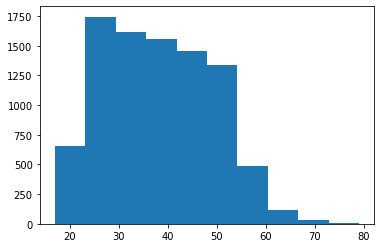

In [16]:
plt.hist(x='age',data=df)

In [17]:
df['minutes'] = pd.to_timedelta(df['time']).dt.seconds//60

(array([  26.,  151.,  455.,  944., 1460., 1792., 1657., 1164.,  817.,
         534.]),
 array([ 68. ,  76.1,  84.2,  92.3, 100.4, 108.5, 116.6, 124.7, 132.8,
        140.9, 149. ]),
 <BarContainer object of 10 artists>)

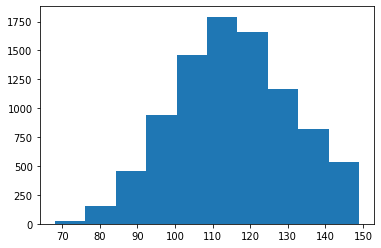

In [18]:
plt.hist(df['minutes'])

In [ ]:
df[df['sex']=='F']['minutes'].min()

In [ ]:
df[df['age']>50]['minutes'].min()

In [ ]:
speed = df['minutes']/21.1
60/min(speed)

# Temperature records

In [5]:
# Location search

adresse = "20 rue des capucins Lyon"
lat,lon = get_lat_lon(adresse)
woeid = get_woeid(lat,lon)

temp = get_temperature_one_day(woeid['woeid'],2020,9,12)

print(lat,lon)
print(woeid['latt_long'])
temp.head()

45.769458 4.834862
45.759392,4.828980


,created,applicable_date,min_temp,max_temp,the_temp
0,2020-09-12T22:35:52.453995Z,2020-09-12,14.270,28.445,27.610
1,2020-09-12T19:35:52.559657Z,2020-09-12,14.270,29.275,27.500
2,2020-09-12T16:35:53.406683Z,2020-09-12,14.270,29.350,27.500
3,2020-09-12T13:35:52.286696Z,2020-09-12,14.225,28.275,27.245
4,2020-09-12T10:35:55.068333Z,2020-09-12,14.210,27.660,27.260


In [9]:
print(woeid['woeid'])

609125


In [ ]:
temp = get_temperature_many_days(woeid['woeid'],2020,9,1,2020,9,30)

In [ ]:
temp_lyon = temp.resample('2H').mean().dropna()
temp_lyon.head()

voir
https://www.meteo-lyon.net/records/mois/septembre


In [ ]:
# adresse = "18 rue ampere 38300 Bourgoin Jallieu"
adresse = "13 rue saint valentin 29820 Guilers"
lat,lon = get_lat_lon(adresse)
woeid = get_woeid(lat,lon)
temp = get_temperature_many_days(woeid['woeid'],2020,9,1,2020,9,30)

In [ ]:
temp_guilers = temp.resample('3H').mean().dropna()

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(temp_lyon.the_temp,color='grey',label='Lyon')
ax.plot(temp_guilers.the_temp,color='b',label='Guilers')
ax.legend()

## Trace GPX

https://www.openrunner.com/

In [13]:
runinlyon = overlayGPX('../data/vienna_marathon.gpx',14)

In [14]:
runinlyon

# Influence de l'environnement urbain

In [ ]:
!pwd

In [2]:
base_path = "data"
item = "BATIMENT"
full_path_dbf = f"{base_path}/{item}.dbf"
full_path_shp = f"{base_path}/{item}.shp"
full_path_prj = f"{base_path}/{item}.prj"

In [3]:
crs_to = pyproj.CRS.from_epsg(2154)
crs_from = pyproj.CRS.from_epsg(4326)
transform = pyproj.Transformer.from_crs(crs_from,crs_to)

---------------------

# usefull readings

## Examples of data science with running data

[2019 Boston Marathon Analysis](https://towardsdatascience.com/running-with-data-ed78d8853ee)


## data types for geoData and dedicaded Python modules 

[reading shapefile with python](https://pypi.org/project/pyshp/)

[shapefile to DataFrame](https://stackoverflow.com/questions/55112771/read-shapefiles-into-dataframe)

PyCRS is a pure Python GIS package for reading, writing, and converting between various common coordinate reference system (CRS) string and data source formats. [PyCRS](https://pypi.org/project/PyCRS/)

[wiki shapefile](https://fr.wikipedia.org/wiki/Shapefile)


Notions de base du système de coordonnées d'un fichier de formes : [ArcGis](https://desktop.arcgis.com/fr/arcmap/10.3/manage-data/shapefiles/fundamentals-of-a-shapefiles-coordinate-system.htm)

Peut être **GeoPandas** simplifira-t-il tout ce travail ?... voir [GeoPandas](https://geopandas.org/index.html)


Créer  un nouveau repo GitHub : [c'est ici](https://kbroman.org/github_tutorial/pages/init.html)


### Selenium

https://selenium-python.readthedocs.io/index.html

https://www.selenium.dev/selenium/docs/api/py/index.html



## Heat island effect 

Research work from Mme Julita Diallo Dudek : [L'Ilot de chaleur urbain : que sait-on de lui ? Comment le mesurer ?](https://www.urbalyon.org/fr/lilot-de-chaleur-urbain-que-sait-de-lui-comment-le-mesurer?#)


## Buildings and cities databases

[IGN](https://geoservices.ign.fr/)
[World Urban Database](http://www.wudapt.org/)


## temperature observation

Voir [Plan climat](https://blogs.grandlyon.com/plan-climat/2015/12/22/les-cartes-de-temperature-du-grand-lyon-en-open-data/) et [Data Grand Lyon](https://data.grandlyon.com/en/accueil)



[Montpellier](http://data.montpellier3m.fr/dataset/thermographie-satellitaire-de-montpellier-mediterranee-metropole)


In [4]:
bati = gpd.GeoDataFrame.from_file(full_path_dbf)

In [5]:
bati.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 890051 entries, 0 to 890050
Data columns (total 26 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   ID          890051 non-null  object  
 1   NATURE      890051 non-null  object  
 2   USAGE1      890051 non-null  object  
 3   USAGE2      96587 non-null   object  
 4   LEGER       890051 non-null  object  
 5   ETAT        890051 non-null  object  
 6   DATE_CREAT  890051 non-null  object  
 7   DATE_MAJ    779661 non-null  object  
 8   DATE_APP    422052 non-null  object  
 9   DATE_CONF   56153 non-null   object  
 10  SOURCE      13510 non-null   object  
 11  ID_SOURCE   531 non-null     object  
 12  PREC_PLANI  890051 non-null  float64 
 13  PREC_ALTI   890051 non-null  float64 
 14  NB_LOGTS    467823 non-null  float64 
 15  NB_ETAGES   467823 non-null  float64 
 16  MAT_MURS    417473 non-null  object  
 17  MAT_TOITS   417485 non-null  object  
 18  HAUTEUR     8785

In [6]:
bati.crs

<Projected CRS: EPSG:2154>
Name: RGF93 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica.
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
bati.head()

In [ ]:
bati['ORIGIN_BAT'].unique()

In [ ]:
bati['USAGE1'].unique()

## Adding building layer to folium map

In [7]:
adresse = "20 rue des capucins Lyon"

In [10]:
lat,lon = get_lat_lon(adresse)
print(f'lat = {lat}')
print(f'lon = {lon}')

x, y = transform.transform(lat,lon)
print(f'x = {x}')
print(f'y = {y}')
dx = 100
dy = 100
x_min = math.floor(x)-dx/2
x_max = math.ceil(x)+dx/2
print('x_min = {:10,.0f}'.format(x_min).replace(',', ' '))
print('x_max = {:10,.0f}'.format(x_max).replace(',', ' '))
y_min = math.floor(y)-dx/2
y_max = math.ceil(y)+dx/2
print('y_min = {:10,.0f}'.format(y_min).replace(',', ' '))
print('y_max = {:10,.0f}'.format(y_max).replace(',', ' '))


lat = 45.769458
lon = 4.834862
x = 842587.460235558
y = 6520528.8046810785
x_min =    842 537
x_max =    842 638
y_min =  6 520 478
y_max =  6 520 579


46


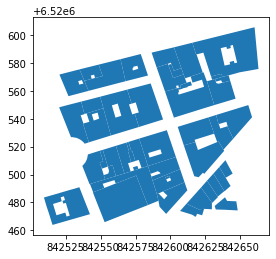

In [11]:
bati_bbox = bati.cx[x_min:x_max, y_min:y_max]

print(len(bati_bbox))
ax = bati_bbox.plot()

In [ ]:
bati_bbox[['USAGE1','USAGE2','HAUTEUR']].head()

In [ ]:
m = draw_map(adresse)
folium.GeoJson(data=bati_bbox["geometry"]).add_to(m)
m

In [ ]:
# parse material table
#
# murs : http://piece-jointe-carto.developpement-durable.gouv.fr/NAT004/DTerNP/html3/annexes/desc_pb40_pevprincipale_dmatgm.html
# toits : http://piece-jointe-carto.developpement-durable.gouv.fr/NAT004/DTerNP/html3/annexes/desc_pb40_pevprincipale_dmatto.html

wall_html = open('data/MATERIAU_MUR.html','r').read()
soup = BeautifulSoup(wall_html, "html.parser")

table_mat = soup.find('table', class_='tableau_descriptif')
list_mat = []
for row in table_mat.findAll("tr"):
    code_mat, mat = row.findAll("td")[0:2]
    list_mat.append([code_mat.text,mat.text])
    
wall_df=pd.DataFrame(list_mat[1:],columns=['code','valeur']).rename(columns={'valeur':'MURS'})

In [ ]:
wall_df.head()

In [ ]:
roof_html = open('data/MATERIAU_TOIT.html','r',encoding='cp1256').read()
soup = BeautifulSoup(roof_html, "html.parser")

table_mat = soup.find('table', class_='tableau_descriptif')
list_mat = []
for row in table_mat.findAll("tr"):
    code_mat, mat = row.findAll("td")[0:2]
    list_mat.append([code_mat.text,mat.text])
    
roof_df=pd.DataFrame(list_mat[1:],columns=['code','valeur']).rename(columns={'valeur':'TOITS'})

In [ ]:
roof_df.head()

In [ ]:
bati_bbox.merge(wall_df,how='inner',left_on='MAT_MURS',right_on='code')\
         .merge(roof_df,how='inner',left_on='MAT_TOITS',right_on='code')\
         [['USAGE1','USAGE2','HAUTEUR','MURS','TOITS']].head()